# Multilayer calculation applet


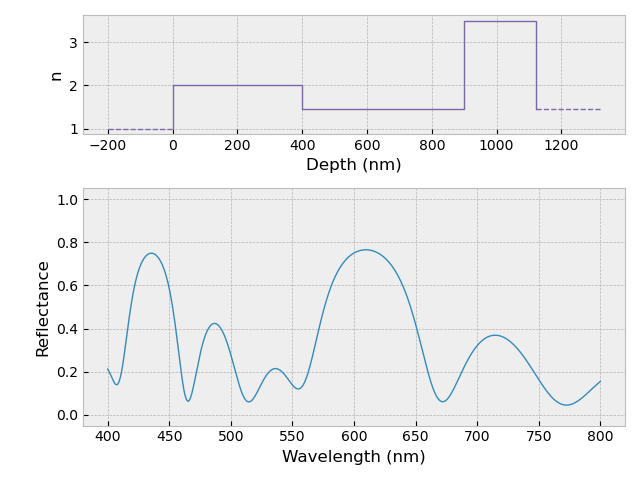

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import ipywidgets as widgets
%matplotlib widget

plt.style.use('bmh')

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.formatter.useoffset'] = False #to avoid the auto-offset on axes

def multilayersolve(thickness,n,thetadeg,pol,wavelength):
    """
    Transfer-matrix method using electric fiels propagating to right and left, from scattering matrices.
    R,T = multilayersolve(th,n,thetadeg,pol,wavel)
    thickness: layer thickness vector (with same units as wavelength)
    n: index vector, including air and substrate at beginning and end. Must have 2 more elements than th.
    thetadeg: incidence angle in deg.
    pol: 1 for TE and -1 for TM
    wavelength = wavelength vector, must have same units as th.
    
    Info in http://fotonica.intec.ugent.be/download/ocs129.pdf
    
    """

    num_lay=thickness.size
    num_w = wavelength.size
    if n.ndim == 1:
        n_mat = np.reshape(np.repeat(n,num_w),(num_lay+2,num_w))
    else:
        n_mat = n
    
    neff0 = n_mat[0]*np.sin(thetadeg/180.*np.pi)
    neff0_sq = neff0 **2
    k0 = 2*np.pi/wavelength
    
    g_air = np.sqrt(n_mat[0]**2-neff0_sq+0j)
    g_su = np.sqrt(n_mat[-1]**2-neff0_sq+0j)
    if pol == -1:
        g_air=g_air/n_mat[0]**2
        g_su=g_su/n_mat[-1]**2
    
    ncostheta=np.sqrt(n_mat[1]**2-neff0_sq+0j)
    gamma=ncostheta
    if pol==-1:
         gamma=gamma/n_mat[1]**2
    
    coeff = gamma/g_air
    t11=.5*(1+coeff)+0j
    t12=.5*(1-coeff)+0j
    t21=t12
    t22=t11
    

    
    for ii in range(num_lay):
    
        delta=k0*thickness[ii]*ncostheta

        prop=np.exp(-1j*delta)
        t11=t11*prop
        t12=t12/prop
        t21=t21*prop
        t22=t22/prop

        ncosthetanew = np.sqrt(n_mat[ii+2]**2-neff0_sq+0j)
        gammanew=ncosthetanew
        if pol==-1:
            gammanew=gammanew/n_mat[ii+2]**2

        coeff=gammanew/gamma;

        m11=0.5*(1+coeff)
        m12=0.5*(1-coeff)
        m21=m12
        m22=m11

        t11new=t11*m11+t12*m21   #Transfer matrix until this layer
        t12new=t11*m12+t12*m22
        t21new=t21*m11+t22*m21
        t22=t21*m12+t22*m22

        t11=t11new
        t12=t12new
        t21=t21new
        
        ncostheta = ncosthetanew
        gamma=gammanew
    
    tra=1/t11
    ref=t21*tra

    REF=abs(ref)**2
    TRA=abs(tra)**2.*np.real(g_su)/np.real(g_air)
    
    return REF, TRA

def gen_prof(thickness,n,tails=200):
    """
    Generates the index profile from list of thicknesses and index.
    z_prof, n_prof = gen_prof(thickness,n,tails=100)
    thickness: thickness array
    n: index array list, with air and substrate as first and last elements, which means its length must be 2 elements more than thickness
    tails is the lengths assigned to the air and substrate layers, def = 100
    """
    n = np.real(n)
    dz_tail = tails
    thickness = np.concatenate([np.array([dz_tail]),thickness,np.array([dz_tail])])
    z_prof = np.zeros(2*(thickness.size))
    n_prof = np.zeros(2*(thickness.size))

    z_0 = -dz_tail
    
    for ii in range(len(thickness)):
        n_prof[(2*ii):(2*ii+2)]=n[ii]
        
        z_prof[2*ii]=z_0
        z_0 += thickness[ii]
        z_prof[2*ii+1]=z_0
    return z_prof, n_prof




layout_slider=widgets.Layout(width='325px')

layout_text = widgets.Layout(width='100px')

index_list_init = np.array([1.0, 2.0, 1.444, 3.5, 1.444])
thickness_list_init = np.array([400.,500.,220.])


sliders_n = [widgets.FloatSlider(min=1., max=4.0, value=index_list_init[ii], step = 0.001, description = f"n{ii}",
                                layout=layout_slider) for ii in range(len(index_list_init))]
sliders_th = [widgets.FloatSlider(min=0., max=4000., value=thickness_list_init[ii], step= 1, description = f"d{ii+1} (nm)",
                                  layout=layout_slider) for ii in range(len(thickness_list_init))]
slider_ang = widgets.FloatSlider(min=0., max=89.9, value=0., step = 0.1, description = '\u03B8 (deg)',
                                layout=layout_slider)
floattext_w1 = widgets.FloatText(value=400.,description='\u03BB min', layout = layout_text, style = {'description_width': '40px'})
floattext_w2 = widgets.FloatText(value=800.,description='\u03BB max', layout = layout_text, style = {'description_width': '40px'})
inttext_num_w = widgets.IntText(value=1000,max = 10000, description='Num. \u03BB',
                                layout = widgets.Layout(width='125px'),
                                style = {'description_width': '50px'})

DBR_slider_w0 = widgets.FloatSlider(min=100, max=2000, value=600, description = "\u03BB 0",
                                layout=layout_slider)
DBR_n_titles = ['n air','nA','nB','n subs']
DBR_index_list_init = [1.,2.0,1.444,3.5]
DBR_sliders_n = [widgets.FloatSlider(min=1., max=4.0, step = 0.001, value=DBR_index_list_init[ii], description = DBR_n_titles[ii],
                                layout=layout_slider) for ii in range(4)]
DBR_slider_duty = widgets.FloatSlider(min=0.1, max=0.9, value=0.5, step= 0.01, description = "duty cycle",
                                  layout=layout_slider)
DBR_slider_numper = widgets.IntSlider(min=0, max=100, value=10, step= 1, description = "Num. periods",
                                  layout=layout_slider)
DBR_tick_extra_lay = widgets.Checkbox(value=True, description = "Extra final layer")


# number_ctrls = widgets.HBox([floattext_w1,floattext_w2,inttext_num_w])
# display(number_ctrls)
first_row = widgets.HBox([slider_ang,floattext_w1,floattext_w2,inttext_num_w])
#display(first_row)

col1= widgets.VBox([widgets.Label()]+sliders_th)
col2= widgets.VBox(sliders_n)

all_cols = widgets.HBox([col1,col2])
string_single_layers = ["Here you can set up to three layers, thickness on the left d (1,2,3) and index on the right n (1,2,3)",
                        "To disable a layer just slide the thickness to zero."]
content_single_layers = widgets.VBox([widgets.Label(st) for st in string_single_layers]+[all_cols, first_row])

string_DBR_tab = ["Here you can set the properties of a two-layer DBR periodic structure.",
                 """The thickness of the layers are set so that the full period has a half-wavelength thickness."""]
DBR_col1 = widgets.VBox([DBR_slider_w0,DBR_slider_duty,DBR_slider_numper,DBR_tick_extra_lay])
DBR_col2 = widgets.VBox(DBR_sliders_n)
DBR_all_cols = widgets.HBox([DBR_col1, DBR_col2])
content_DBR_tab = widgets.VBox([widgets.Label(st) for st in string_DBR_tab]+[DBR_all_cols, first_row])


children = [content_single_layers, content_DBR_tab]

tab = widgets.Tab(layout = widgets.Layout(width = '700px'))
#tab = widgets.Tab()
tab.children = children
tab_titles = ['Single layers','Periodic structure']
for ii,title in enumerate(tab_titles):
    tab.set_title(ii,title)
display(tab)
    

    

all_widgets = sliders_n+sliders_th+[slider_ang,floattext_w1,floattext_w2,inttext_num_w]
all_widgets += [DBR_slider_w0,DBR_slider_duty,DBR_slider_numper,DBR_tick_extra_lay]+DBR_sliders_n


# all_widgets = [slider_w]+sliders_n+sliders_th+[slider_ang,floattext_w1,floattext_w2,inttext_num_w]

def calc_multilay(obj):
    thetadeg=slider_ang.value
    
    if inttext_num_w.value > 10000:
        inttext_num_w.value = 10000
        
    w=np.linspace(floattext_w1.value,floattext_w2.value,inttext_num_w.value)
    
    if tab.selected_index == 0:
        n_list = np.array([aa.value for aa in sliders_n])
        th_list = np.array([aa.value for aa in sliders_th])
        
        #now I remove zero-length layers
        thickness_with_tails = np.concatenate(([10.],th_list,[10.]))
        n_list = n_list[thickness_with_tails>0]
        th_list=th_list[th_list>0]
    else:
        w0=DBR_slider_w0.value
        n1 = DBR_sliders_n[1].value
        n2 = DBR_sliders_n[2].value
        n_air = DBR_sliders_n[0].value
        n_su = DBR_sliders_n[-1].value
        duty = DBR_slider_duty.value
        periods = DBR_slider_numper.value
        th1=w0/2./n1*duty
        th2=w0/2./n2*(1-duty)
        th_list = np.tile(np.array([th1,th2]),periods)
        n_list = np.tile(np.array([n1,n2]),periods)
        if DBR_tick_extra_lay.value:
            th_list=np.append(th_list,th1)
            n_list=np.append(n_list,n1)

        n_list = np.concatenate([np.array([n_air]),n_list,np.array([n_su])])


    R,T = multilayersolve(thickness=th_list,n=n_list,thetadeg=thetadeg,pol=1,wavelength=w)
    
    if thetadeg == 0.:
        R2 = R
        T2 = T
    else:
        R2,T2 = multilayersolve(thickness=th_list,n=n_list,thetadeg=thetadeg,pol=-1,wavelength=w)
    
    
    z_prof,n_prof = gen_prof(th_list,n_list)

    ax1.clear()
    ax2.clear()

    ax1.plot(z_prof[1:-1],n_prof[1:-1],color='C2')
    ax1.plot(z_prof[:2],n_prof[:2],'--',color = 'C2')
    ax1.plot(z_prof[-2:],n_prof[-2:],'--', color='C2')
    ax2.plot(w,R)
    if thetadeg>0:
        ax2.plot(w,R2)
        
    ax1.set_xlabel('Depth (nm)')
    ax1.set_ylabel('n')
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Reflectance')
    ax2.set_ylim([-.05,1.05])
    if thetadeg>0:
        ax2.legend(['TE','TM'], loc = 'upper right')
    fig.canvas.draw()
    

fig,(ax1,ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios': [1,2]})
ax1.plot([])
ax2.plot([])
ax1.set_xlabel('Depth (nm)')
ax1.set_ylabel('n')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Reflectance')
fig.canvas.header_visible = False
fig.tight_layout()

calc_multilay(None)

[widg.observe(calc_multilay,names = 'value') for widg in all_widgets]
tab.observe(calc_multilay,names = 'selected_index')

None
